# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

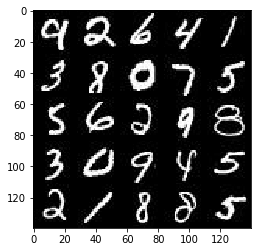

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

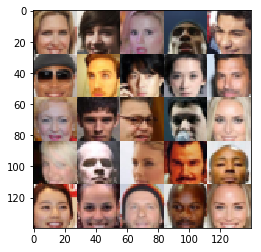

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 'inputs')
    z = tf.placeholder(tf.float32, (None, z_dim), 'z_input')
    learning_rate = tf.placeholder(tf.float32, None, 'learning_rate')

    return inputs, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    kernel_size = 5

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, kernel_size, strides=2, padding='same')
        #no batch norm on first layer
        relu1 = tf.nn.leaky_relu(x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, kernel_size, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.nn.leaky_relu(bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, kernel_size, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.nn.leaky_relu(bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        dropout = tf.layers.dropout(logits, rate=0.5)
        out = tf.sigmoid(dropout)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    kernel_size = 5
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.leaky_relu(x1)
        # 7x7x512 now

        #stride one!
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.leaky_relu(x2)
        # 14x14x256

        x3 = tf.layers.conv2d_transpose(x2, 128, kernel_size, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.leaky_relu(x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size, strides=1, padding='same')
        # 28x28x3 now
        
        dropout = tf.layers.dropout(logits, rate=0.5)
        
        out = tf.tanh(dropout)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    z_size = z_dim

    class Gan:
        def __init__(self, real_size, z_size, beta1=0.5):
            self.input_real, self.input_z, self.learning_rate = model_inputs(real_size[0], real_size[1], real_size[2], z_size)
            self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[2])
            self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)
        
    net = Gan((data_shape[1], data_shape[2], data_shape[3]), z_size, beta1)
    out_channel_dim = data_shape[3]
    
    steps = 0
    print_every=10
    show_every=100
    n_images = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                #rescale to -1 to +1
                batch_images = 2 * batch_images
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z, net.learning_rate: learning_rate})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images, net.learning_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Step {} ".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, net.input_z, out_channel_dim, data_image_mode)


#         saver.save(sess, './checkpoints/generator.ckpt')


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 10  Discriminator Loss: 0.5071... Generator Loss: 5.7969
Epoch 1/2... Step 20  Discriminator Loss: 0.3470... Generator Loss: 6.8084
Epoch 1/2... Step 30  Discriminator Loss: 4.2298... Generator Loss: 1.0161
Epoch 1/2... Step 40  Discriminator Loss: 0.4022... Generator Loss: 3.8715
Epoch 1/2... Step 50  Discriminator Loss: 0.9015... Generator Loss: 1.4456
Epoch 1/2... Step 60  Discriminator Loss: 0.5823... Generator Loss: 3.3926
Epoch 1/2... Step 70  Discriminator Loss: 0.3455... Generator Loss: 6.5635
Epoch 1/2... Step 80  Discriminator Loss: 1.7003... Generator Loss: 5.3800
Epoch 1/2... Step 90  Discriminator Loss: 1.5257... Generator Loss: 1.7510
Epoch 1/2... Step 100  Discriminator Loss: 0.7122... Generator Loss: 1.7753


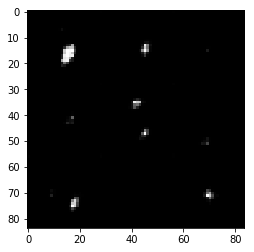

Epoch 1/2... Step 110  Discriminator Loss: 1.0193... Generator Loss: 1.4137
Epoch 1/2... Step 120  Discriminator Loss: 0.8447... Generator Loss: 1.5857
Epoch 1/2... Step 130  Discriminator Loss: 1.1539... Generator Loss: 1.0228
Epoch 1/2... Step 140  Discriminator Loss: 1.0684... Generator Loss: 0.9006
Epoch 1/2... Step 150  Discriminator Loss: 0.9572... Generator Loss: 1.1951
Epoch 1/2... Step 160  Discriminator Loss: 1.1941... Generator Loss: 0.6997
Epoch 1/2... Step 170  Discriminator Loss: 1.3953... Generator Loss: 3.1083
Epoch 1/2... Step 180  Discriminator Loss: 1.8489... Generator Loss: 0.3146
Epoch 1/2... Step 190  Discriminator Loss: 0.8515... Generator Loss: 2.9435
Epoch 1/2... Step 200  Discriminator Loss: 1.5571... Generator Loss: 0.4909


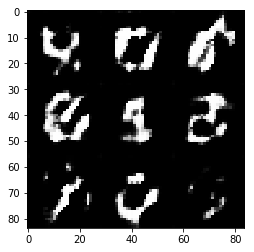

Epoch 1/2... Step 210  Discriminator Loss: 0.9488... Generator Loss: 1.4832
Epoch 1/2... Step 220  Discriminator Loss: 1.1105... Generator Loss: 0.7880
Epoch 1/2... Step 230  Discriminator Loss: 1.3027... Generator Loss: 0.7258
Epoch 1/2... Step 240  Discriminator Loss: 0.8291... Generator Loss: 1.5422
Epoch 1/2... Step 250  Discriminator Loss: 0.5661... Generator Loss: 1.9889
Epoch 1/2... Step 260  Discriminator Loss: 0.8440... Generator Loss: 2.4122
Epoch 1/2... Step 270  Discriminator Loss: 1.0786... Generator Loss: 3.4649
Epoch 1/2... Step 280  Discriminator Loss: 0.7519... Generator Loss: 2.4792
Epoch 1/2... Step 290  Discriminator Loss: 0.9620... Generator Loss: 1.1740
Epoch 1/2... Step 300  Discriminator Loss: 1.2790... Generator Loss: 0.7420


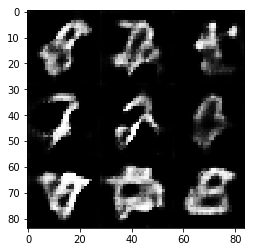

Epoch 1/2... Step 310  Discriminator Loss: 1.1158... Generator Loss: 1.0322
Epoch 1/2... Step 320  Discriminator Loss: 2.5103... Generator Loss: 3.8343
Epoch 1/2... Step 330  Discriminator Loss: 1.1391... Generator Loss: 0.8101
Epoch 1/2... Step 340  Discriminator Loss: 2.0760... Generator Loss: 2.8753
Epoch 1/2... Step 350  Discriminator Loss: 1.2028... Generator Loss: 1.1217
Epoch 1/2... Step 360  Discriminator Loss: 1.2431... Generator Loss: 0.7552
Epoch 1/2... Step 370  Discriminator Loss: 1.1297... Generator Loss: 1.4194
Epoch 1/2... Step 380  Discriminator Loss: 0.9995... Generator Loss: 1.4937
Epoch 1/2... Step 390  Discriminator Loss: 1.1875... Generator Loss: 0.7450
Epoch 1/2... Step 400  Discriminator Loss: 1.0017... Generator Loss: 1.1907


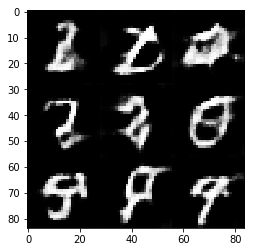

Epoch 1/2... Step 410  Discriminator Loss: 1.1304... Generator Loss: 0.7756
Epoch 1/2... Step 420  Discriminator Loss: 1.1461... Generator Loss: 0.8464
Epoch 1/2... Step 430  Discriminator Loss: 1.2742... Generator Loss: 0.5820
Epoch 1/2... Step 440  Discriminator Loss: 1.0355... Generator Loss: 0.9814
Epoch 1/2... Step 450  Discriminator Loss: 1.5060... Generator Loss: 2.0763
Epoch 1/2... Step 460  Discriminator Loss: 1.1768... Generator Loss: 0.8759
Epoch 1/2... Step 470  Discriminator Loss: 1.5374... Generator Loss: 0.4865
Epoch 1/2... Step 480  Discriminator Loss: 1.0863... Generator Loss: 0.8595
Epoch 1/2... Step 490  Discriminator Loss: 1.0477... Generator Loss: 1.3456
Epoch 1/2... Step 500  Discriminator Loss: 1.0521... Generator Loss: 1.1957


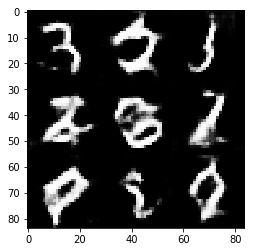

Epoch 1/2... Step 510  Discriminator Loss: 1.2320... Generator Loss: 1.5237
Epoch 1/2... Step 520  Discriminator Loss: 1.2722... Generator Loss: 0.6642
Epoch 1/2... Step 530  Discriminator Loss: 1.4291... Generator Loss: 0.5126
Epoch 1/2... Step 540  Discriminator Loss: 1.1604... Generator Loss: 0.8449
Epoch 1/2... Step 550  Discriminator Loss: 1.3624... Generator Loss: 0.5444
Epoch 1/2... Step 560  Discriminator Loss: 1.2449... Generator Loss: 0.6572
Epoch 1/2... Step 570  Discriminator Loss: 1.1224... Generator Loss: 1.6946
Epoch 1/2... Step 580  Discriminator Loss: 1.4463... Generator Loss: 0.5099
Epoch 1/2... Step 590  Discriminator Loss: 1.1498... Generator Loss: 1.1629
Epoch 1/2... Step 600  Discriminator Loss: 1.1232... Generator Loss: 0.8659


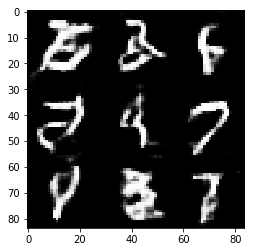

Epoch 1/2... Step 610  Discriminator Loss: 1.2861... Generator Loss: 0.5985
Epoch 1/2... Step 620  Discriminator Loss: 0.9391... Generator Loss: 1.5097
Epoch 1/2... Step 630  Discriminator Loss: 1.0071... Generator Loss: 1.1561
Epoch 1/2... Step 640  Discriminator Loss: 1.2761... Generator Loss: 1.4265
Epoch 1/2... Step 650  Discriminator Loss: 0.9949... Generator Loss: 1.2481
Epoch 1/2... Step 660  Discriminator Loss: 1.0655... Generator Loss: 1.2395
Epoch 1/2... Step 670  Discriminator Loss: 1.7436... Generator Loss: 0.3627
Epoch 1/2... Step 680  Discriminator Loss: 1.2594... Generator Loss: 0.7205
Epoch 1/2... Step 690  Discriminator Loss: 1.2723... Generator Loss: 0.5763
Epoch 1/2... Step 700  Discriminator Loss: 1.0611... Generator Loss: 0.8264


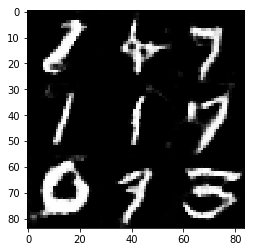

Epoch 1/2... Step 710  Discriminator Loss: 1.1541... Generator Loss: 0.9850
Epoch 1/2... Step 720  Discriminator Loss: 1.3052... Generator Loss: 0.6421
Epoch 1/2... Step 730  Discriminator Loss: 1.0589... Generator Loss: 0.9948
Epoch 1/2... Step 740  Discriminator Loss: 1.0425... Generator Loss: 1.6675
Epoch 1/2... Step 750  Discriminator Loss: 1.2762... Generator Loss: 2.0203
Epoch 1/2... Step 760  Discriminator Loss: 1.0301... Generator Loss: 1.0468
Epoch 1/2... Step 770  Discriminator Loss: 1.1664... Generator Loss: 0.7959
Epoch 1/2... Step 780  Discriminator Loss: 1.0608... Generator Loss: 1.6085
Epoch 1/2... Step 790  Discriminator Loss: 1.6790... Generator Loss: 0.4098
Epoch 1/2... Step 800  Discriminator Loss: 1.0281... Generator Loss: 0.9420


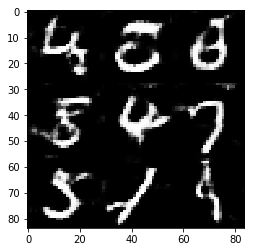

Epoch 1/2... Step 810  Discriminator Loss: 1.1650... Generator Loss: 0.7923
Epoch 1/2... Step 820  Discriminator Loss: 1.0446... Generator Loss: 1.0045
Epoch 1/2... Step 830  Discriminator Loss: 1.2809... Generator Loss: 1.8397
Epoch 1/2... Step 840  Discriminator Loss: 1.1032... Generator Loss: 0.8117
Epoch 1/2... Step 850  Discriminator Loss: 1.1364... Generator Loss: 0.9661
Epoch 1/2... Step 860  Discriminator Loss: 1.0802... Generator Loss: 1.0834
Epoch 1/2... Step 870  Discriminator Loss: 1.1496... Generator Loss: 0.8077
Epoch 1/2... Step 880  Discriminator Loss: 1.1657... Generator Loss: 1.8070
Epoch 1/2... Step 890  Discriminator Loss: 1.1077... Generator Loss: 1.0351
Epoch 1/2... Step 900  Discriminator Loss: 1.0451... Generator Loss: 0.9204


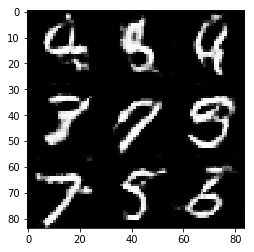

Epoch 1/2... Step 910  Discriminator Loss: 1.1331... Generator Loss: 0.8899
Epoch 1/2... Step 920  Discriminator Loss: 0.9672... Generator Loss: 1.3967
Epoch 1/2... Step 930  Discriminator Loss: 1.2203... Generator Loss: 0.6775
Epoch 2/2... Step 940  Discriminator Loss: 1.0132... Generator Loss: 1.6275
Epoch 2/2... Step 950  Discriminator Loss: 0.9550... Generator Loss: 1.1632
Epoch 2/2... Step 960  Discriminator Loss: 1.0430... Generator Loss: 0.8819
Epoch 2/2... Step 970  Discriminator Loss: 1.3055... Generator Loss: 0.6301
Epoch 2/2... Step 980  Discriminator Loss: 1.0882... Generator Loss: 0.8573
Epoch 2/2... Step 990  Discriminator Loss: 0.9783... Generator Loss: 0.9460
Epoch 2/2... Step 1000  Discriminator Loss: 1.6075... Generator Loss: 0.4116


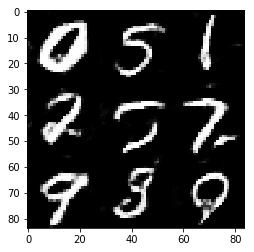

Epoch 2/2... Step 1010  Discriminator Loss: 1.2008... Generator Loss: 0.7451
Epoch 2/2... Step 1020  Discriminator Loss: 1.7833... Generator Loss: 2.5649
Epoch 2/2... Step 1030  Discriminator Loss: 1.0290... Generator Loss: 0.8658
Epoch 2/2... Step 1040  Discriminator Loss: 1.2398... Generator Loss: 0.6538
Epoch 2/2... Step 1050  Discriminator Loss: 1.6431... Generator Loss: 2.9993
Epoch 2/2... Step 1060  Discriminator Loss: 1.0024... Generator Loss: 0.9676
Epoch 2/2... Step 1070  Discriminator Loss: 1.1428... Generator Loss: 0.7581
Epoch 2/2... Step 1080  Discriminator Loss: 1.1673... Generator Loss: 0.7295
Epoch 2/2... Step 1090  Discriminator Loss: 1.0037... Generator Loss: 1.2254
Epoch 2/2... Step 1100  Discriminator Loss: 0.9917... Generator Loss: 0.9919


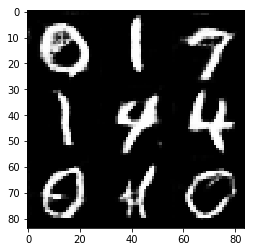

Epoch 2/2... Step 1110  Discriminator Loss: 1.1292... Generator Loss: 1.8997
Epoch 2/2... Step 1120  Discriminator Loss: 1.1729... Generator Loss: 0.7385
Epoch 2/2... Step 1130  Discriminator Loss: 1.1550... Generator Loss: 0.7767
Epoch 2/2... Step 1140  Discriminator Loss: 0.8990... Generator Loss: 1.0055
Epoch 2/2... Step 1150  Discriminator Loss: 0.7357... Generator Loss: 1.4070
Epoch 2/2... Step 1160  Discriminator Loss: 1.2885... Generator Loss: 0.8920
Epoch 2/2... Step 1170  Discriminator Loss: 1.3482... Generator Loss: 1.9422
Epoch 2/2... Step 1180  Discriminator Loss: 1.0614... Generator Loss: 0.9897
Epoch 2/2... Step 1190  Discriminator Loss: 0.8369... Generator Loss: 1.2425
Epoch 2/2... Step 1200  Discriminator Loss: 1.2332... Generator Loss: 1.5263


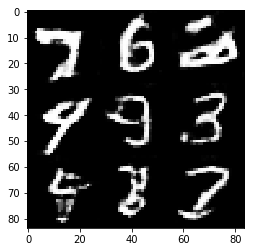

Epoch 2/2... Step 1210  Discriminator Loss: 1.0586... Generator Loss: 0.9601
Epoch 2/2... Step 1220  Discriminator Loss: 1.0048... Generator Loss: 1.0445
Epoch 2/2... Step 1230  Discriminator Loss: 1.0368... Generator Loss: 1.0323
Epoch 2/2... Step 1240  Discriminator Loss: 0.9465... Generator Loss: 1.0479
Epoch 2/2... Step 1250  Discriminator Loss: 1.6703... Generator Loss: 0.3971
Epoch 2/2... Step 1260  Discriminator Loss: 1.2221... Generator Loss: 0.7074
Epoch 2/2... Step 1270  Discriminator Loss: 0.9503... Generator Loss: 1.3839
Epoch 2/2... Step 1280  Discriminator Loss: 1.0762... Generator Loss: 1.2761
Epoch 2/2... Step 1290  Discriminator Loss: 1.1672... Generator Loss: 0.7394
Epoch 2/2... Step 1300  Discriminator Loss: 1.1403... Generator Loss: 1.0047


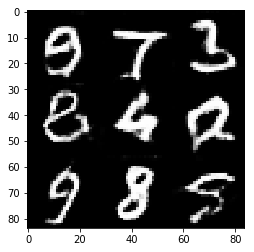

Epoch 2/2... Step 1310  Discriminator Loss: 1.0439... Generator Loss: 1.1065
Epoch 2/2... Step 1320  Discriminator Loss: 0.9189... Generator Loss: 1.2186
Epoch 2/2... Step 1330  Discriminator Loss: 1.2236... Generator Loss: 0.6909
Epoch 2/2... Step 1340  Discriminator Loss: 1.1303... Generator Loss: 0.7949
Epoch 2/2... Step 1350  Discriminator Loss: 1.0056... Generator Loss: 2.0191
Epoch 2/2... Step 1360  Discriminator Loss: 0.8109... Generator Loss: 1.7263
Epoch 2/2... Step 1370  Discriminator Loss: 1.9984... Generator Loss: 0.2852
Epoch 2/2... Step 1380  Discriminator Loss: 0.8087... Generator Loss: 1.5560
Epoch 2/2... Step 1390  Discriminator Loss: 1.2977... Generator Loss: 0.6194
Epoch 2/2... Step 1400  Discriminator Loss: 1.1462... Generator Loss: 1.1052


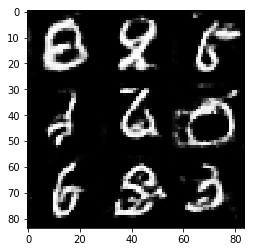

Epoch 2/2... Step 1410  Discriminator Loss: 0.9226... Generator Loss: 1.3866
Epoch 2/2... Step 1420  Discriminator Loss: 1.1602... Generator Loss: 0.8154
Epoch 2/2... Step 1430  Discriminator Loss: 0.9032... Generator Loss: 1.3842
Epoch 2/2... Step 1440  Discriminator Loss: 1.3587... Generator Loss: 0.5273
Epoch 2/2... Step 1450  Discriminator Loss: 0.7390... Generator Loss: 1.7267
Epoch 2/2... Step 1460  Discriminator Loss: 2.1435... Generator Loss: 0.2649
Epoch 2/2... Step 1470  Discriminator Loss: 0.7614... Generator Loss: 1.7048
Epoch 2/2... Step 1480  Discriminator Loss: 1.6995... Generator Loss: 0.4045
Epoch 2/2... Step 1490  Discriminator Loss: 1.2353... Generator Loss: 2.3509
Epoch 2/2... Step 1500  Discriminator Loss: 1.7503... Generator Loss: 0.3566


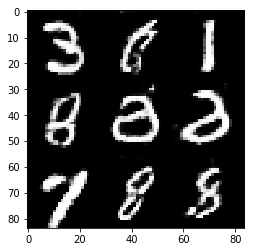

Epoch 2/2... Step 1510  Discriminator Loss: 0.6450... Generator Loss: 1.7431
Epoch 2/2... Step 1520  Discriminator Loss: 0.6511... Generator Loss: 1.8216
Epoch 2/2... Step 1530  Discriminator Loss: 2.1611... Generator Loss: 0.3199
Epoch 2/2... Step 1540  Discriminator Loss: 1.2064... Generator Loss: 0.7596
Epoch 2/2... Step 1550  Discriminator Loss: 0.9720... Generator Loss: 1.4989
Epoch 2/2... Step 1560  Discriminator Loss: 1.0475... Generator Loss: 0.8845
Epoch 2/2... Step 1570  Discriminator Loss: 0.7999... Generator Loss: 1.7590
Epoch 2/2... Step 1580  Discriminator Loss: 1.5404... Generator Loss: 0.4957
Epoch 2/2... Step 1590  Discriminator Loss: 1.7043... Generator Loss: 0.4212
Epoch 2/2... Step 1600  Discriminator Loss: 0.6879... Generator Loss: 1.6161


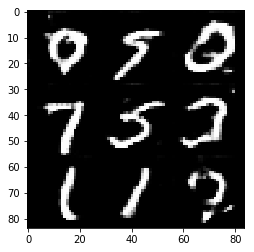

Epoch 2/2... Step 1610  Discriminator Loss: 0.9883... Generator Loss: 1.1361
Epoch 2/2... Step 1620  Discriminator Loss: 1.0635... Generator Loss: 2.0049
Epoch 2/2... Step 1630  Discriminator Loss: 1.0184... Generator Loss: 1.0868
Epoch 2/2... Step 1640  Discriminator Loss: 0.8258... Generator Loss: 1.2279
Epoch 2/2... Step 1650  Discriminator Loss: 1.1912... Generator Loss: 0.9493
Epoch 2/2... Step 1660  Discriminator Loss: 1.1258... Generator Loss: 0.9578
Epoch 2/2... Step 1670  Discriminator Loss: 0.9729... Generator Loss: 1.0148
Epoch 2/2... Step 1680  Discriminator Loss: 0.8609... Generator Loss: 1.1610
Epoch 2/2... Step 1690  Discriminator Loss: 0.8210... Generator Loss: 1.5337
Epoch 2/2... Step 1700  Discriminator Loss: 0.9061... Generator Loss: 2.5164


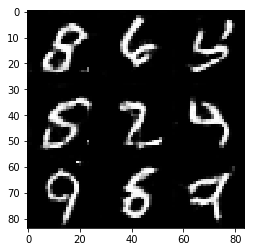

Epoch 2/2... Step 1710  Discriminator Loss: 0.8214... Generator Loss: 1.2452
Epoch 2/2... Step 1720  Discriminator Loss: 1.3608... Generator Loss: 0.5872
Epoch 2/2... Step 1730  Discriminator Loss: 0.6549... Generator Loss: 1.7855
Epoch 2/2... Step 1740  Discriminator Loss: 0.6433... Generator Loss: 1.6622
Epoch 2/2... Step 1750  Discriminator Loss: 1.2583... Generator Loss: 3.5077
Epoch 2/2... Step 1760  Discriminator Loss: 1.2174... Generator Loss: 0.8087
Epoch 2/2... Step 1770  Discriminator Loss: 1.6116... Generator Loss: 2.6875
Epoch 2/2... Step 1780  Discriminator Loss: 0.9898... Generator Loss: 1.5018
Epoch 2/2... Step 1790  Discriminator Loss: 0.9425... Generator Loss: 1.3997
Epoch 2/2... Step 1800  Discriminator Loss: 1.2482... Generator Loss: 0.6702


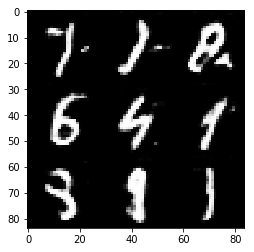

Epoch 2/2... Step 1810  Discriminator Loss: 0.9577... Generator Loss: 0.9691
Epoch 2/2... Step 1820  Discriminator Loss: 0.8569... Generator Loss: 1.0764
Epoch 2/2... Step 1830  Discriminator Loss: 1.6481... Generator Loss: 2.7599
Epoch 2/2... Step 1840  Discriminator Loss: 1.2169... Generator Loss: 0.7601
Epoch 2/2... Step 1850  Discriminator Loss: 1.1157... Generator Loss: 0.7987
Epoch 2/2... Step 1860  Discriminator Loss: 0.7106... Generator Loss: 1.8267
Epoch 2/2... Step 1870  Discriminator Loss: 1.2290... Generator Loss: 0.6806


In [29]:
batch_size = 64 #128
z_dim = 100
learning_rate = 0.001 #0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 10  Discriminator Loss: 0.7160... Generator Loss: 2.0280
Epoch 1/1... Step 20  Discriminator Loss: 0.3944... Generator Loss: 4.5772
Epoch 1/1... Step 30  Discriminator Loss: 0.4311... Generator Loss: 3.0344
Epoch 1/1... Step 40  Discriminator Loss: 1.1655... Generator Loss: 0.8544
Epoch 1/1... Step 50  Discriminator Loss: 0.7917... Generator Loss: 1.3061
Epoch 1/1... Step 60  Discriminator Loss: 1.0404... Generator Loss: 1.0441
Epoch 1/1... Step 70  Discriminator Loss: 0.9035... Generator Loss: 2.1348
Epoch 1/1... Step 80  Discriminator Loss: 0.9830... Generator Loss: 1.0220
Epoch 1/1... Step 90  Discriminator Loss: 0.6223... Generator Loss: 4.4477
Epoch 1/1... Step 100  Discriminator Loss: 0.7167... Generator Loss: 1.5345


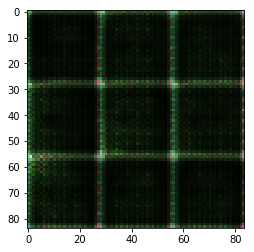

Epoch 1/1... Step 110  Discriminator Loss: 0.5708... Generator Loss: 2.0066
Epoch 1/1... Step 120  Discriminator Loss: 1.2927... Generator Loss: 0.6555
Epoch 1/1... Step 130  Discriminator Loss: 0.5572... Generator Loss: 2.1843
Epoch 1/1... Step 140  Discriminator Loss: 0.5323... Generator Loss: 5.0663
Epoch 1/1... Step 150  Discriminator Loss: 0.4667... Generator Loss: 2.7621
Epoch 1/1... Step 160  Discriminator Loss: 0.7945... Generator Loss: 1.3948
Epoch 1/1... Step 170  Discriminator Loss: 0.6837... Generator Loss: 4.9331
Epoch 1/1... Step 180  Discriminator Loss: 1.9173... Generator Loss: 5.8628
Epoch 1/1... Step 190  Discriminator Loss: 1.0443... Generator Loss: 1.0906
Epoch 1/1... Step 200  Discriminator Loss: 0.7651... Generator Loss: 1.5080


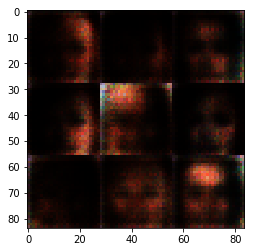

Epoch 1/1... Step 210  Discriminator Loss: 0.6250... Generator Loss: 3.0092
Epoch 1/1... Step 220  Discriminator Loss: 0.7128... Generator Loss: 1.5923
Epoch 1/1... Step 230  Discriminator Loss: 0.4656... Generator Loss: 3.3956
Epoch 1/1... Step 240  Discriminator Loss: 0.4813... Generator Loss: 2.5387
Epoch 1/1... Step 250  Discriminator Loss: 0.6207... Generator Loss: 1.8326
Epoch 1/1... Step 260  Discriminator Loss: 1.0943... Generator Loss: 0.7163
Epoch 1/1... Step 270  Discriminator Loss: 0.5818... Generator Loss: 2.4693
Epoch 1/1... Step 280  Discriminator Loss: 0.9114... Generator Loss: 1.0835
Epoch 1/1... Step 290  Discriminator Loss: 2.2930... Generator Loss: 0.1912
Epoch 1/1... Step 300  Discriminator Loss: 1.6744... Generator Loss: 0.3710


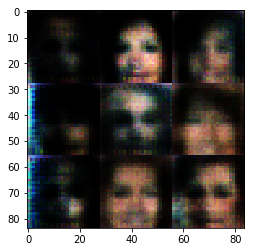

Epoch 1/1... Step 310  Discriminator Loss: 1.2920... Generator Loss: 0.7492
Epoch 1/1... Step 320  Discriminator Loss: 0.6018... Generator Loss: 2.7060
Epoch 1/1... Step 330  Discriminator Loss: 0.5928... Generator Loss: 1.7924
Epoch 1/1... Step 340  Discriminator Loss: 0.5962... Generator Loss: 1.7680
Epoch 1/1... Step 350  Discriminator Loss: 0.8174... Generator Loss: 1.0954
Epoch 1/1... Step 360  Discriminator Loss: 1.5819... Generator Loss: 0.4330
Epoch 1/1... Step 370  Discriminator Loss: 0.6000... Generator Loss: 1.6588
Epoch 1/1... Step 380  Discriminator Loss: 1.9122... Generator Loss: 2.8485
Epoch 1/1... Step 390  Discriminator Loss: 1.0722... Generator Loss: 0.7487
Epoch 1/1... Step 400  Discriminator Loss: 0.6332... Generator Loss: 2.5231


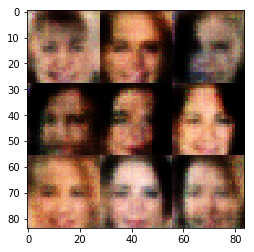

Epoch 1/1... Step 410  Discriminator Loss: 0.5652... Generator Loss: 2.9859
Epoch 1/1... Step 420  Discriminator Loss: 1.7142... Generator Loss: 0.4578
Epoch 1/1... Step 430  Discriminator Loss: 0.6099... Generator Loss: 2.1102
Epoch 1/1... Step 440  Discriminator Loss: 2.3138... Generator Loss: 0.1918
Epoch 1/1... Step 450  Discriminator Loss: 0.9427... Generator Loss: 1.0957
Epoch 1/1... Step 460  Discriminator Loss: 0.6234... Generator Loss: 1.9829
Epoch 1/1... Step 470  Discriminator Loss: 0.8359... Generator Loss: 1.2801
Epoch 1/1... Step 480  Discriminator Loss: 1.9157... Generator Loss: 0.2924
Epoch 1/1... Step 490  Discriminator Loss: 0.7101... Generator Loss: 1.8417
Epoch 1/1... Step 500  Discriminator Loss: 1.1690... Generator Loss: 0.8125


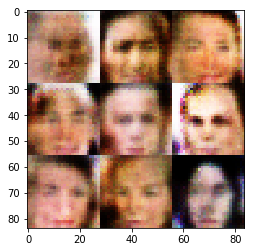

Epoch 1/1... Step 510  Discriminator Loss: 1.3767... Generator Loss: 1.9516
Epoch 1/1... Step 520  Discriminator Loss: 1.3479... Generator Loss: 0.5297
Epoch 1/1... Step 530  Discriminator Loss: 1.0370... Generator Loss: 1.1370
Epoch 1/1... Step 540  Discriminator Loss: 0.9241... Generator Loss: 1.6247
Epoch 1/1... Step 550  Discriminator Loss: 0.5648... Generator Loss: 2.2206
Epoch 1/1... Step 560  Discriminator Loss: 1.9109... Generator Loss: 2.5431
Epoch 1/1... Step 570  Discriminator Loss: 1.0603... Generator Loss: 1.7965
Epoch 1/1... Step 580  Discriminator Loss: 1.0019... Generator Loss: 0.8178
Epoch 1/1... Step 590  Discriminator Loss: 0.6510... Generator Loss: 2.2895
Epoch 1/1... Step 600  Discriminator Loss: 1.5103... Generator Loss: 2.4132


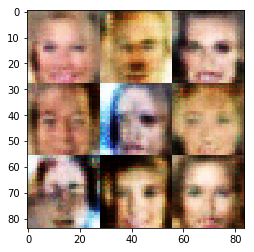

Epoch 1/1... Step 610  Discriminator Loss: 0.5062... Generator Loss: 2.8959
Epoch 1/1... Step 620  Discriminator Loss: 1.1423... Generator Loss: 1.9263
Epoch 1/1... Step 630  Discriminator Loss: 0.5048... Generator Loss: 3.5116
Epoch 1/1... Step 640  Discriminator Loss: 1.0057... Generator Loss: 1.1649
Epoch 1/1... Step 650  Discriminator Loss: 0.4967... Generator Loss: 2.6222
Epoch 1/1... Step 660  Discriminator Loss: 0.7724... Generator Loss: 1.2041
Epoch 1/1... Step 670  Discriminator Loss: 1.3658... Generator Loss: 0.5041
Epoch 1/1... Step 680  Discriminator Loss: 0.6225... Generator Loss: 1.7584
Epoch 1/1... Step 690  Discriminator Loss: 1.0818... Generator Loss: 0.7332
Epoch 1/1... Step 700  Discriminator Loss: 0.5639... Generator Loss: 2.3350


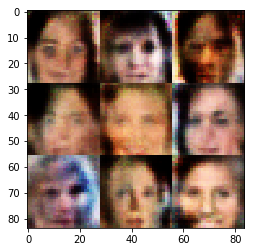

Epoch 1/1... Step 710  Discriminator Loss: 1.0284... Generator Loss: 0.8894
Epoch 1/1... Step 720  Discriminator Loss: 0.9602... Generator Loss: 0.8789
Epoch 1/1... Step 730  Discriminator Loss: 0.5887... Generator Loss: 1.8423
Epoch 1/1... Step 740  Discriminator Loss: 0.5800... Generator Loss: 1.7975
Epoch 1/1... Step 750  Discriminator Loss: 0.4990... Generator Loss: 3.7148
Epoch 1/1... Step 760  Discriminator Loss: 0.9327... Generator Loss: 2.9895
Epoch 1/1... Step 770  Discriminator Loss: 0.8266... Generator Loss: 1.4266
Epoch 1/1... Step 780  Discriminator Loss: 1.0877... Generator Loss: 0.7424
Epoch 1/1... Step 790  Discriminator Loss: 1.0318... Generator Loss: 0.8119
Epoch 1/1... Step 800  Discriminator Loss: 1.2337... Generator Loss: 1.6136


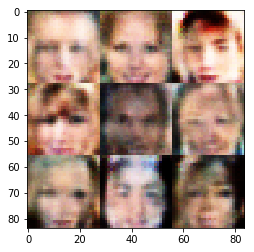

Epoch 1/1... Step 810  Discriminator Loss: 0.8547... Generator Loss: 2.7022
Epoch 1/1... Step 820  Discriminator Loss: 1.0277... Generator Loss: 0.8007
Epoch 1/1... Step 830  Discriminator Loss: 0.7792... Generator Loss: 1.0966
Epoch 1/1... Step 840  Discriminator Loss: 1.2452... Generator Loss: 0.6401
Epoch 1/1... Step 850  Discriminator Loss: 0.6556... Generator Loss: 1.6232
Epoch 1/1... Step 860  Discriminator Loss: 0.5282... Generator Loss: 2.0630
Epoch 1/1... Step 870  Discriminator Loss: 0.7887... Generator Loss: 1.3224
Epoch 1/1... Step 880  Discriminator Loss: 1.5800... Generator Loss: 0.4017
Epoch 1/1... Step 890  Discriminator Loss: 0.9631... Generator Loss: 0.8891
Epoch 1/1... Step 900  Discriminator Loss: 0.7729... Generator Loss: 1.8722


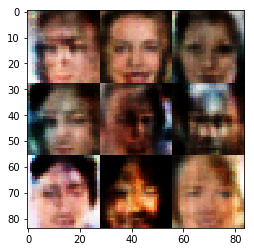

Epoch 1/1... Step 910  Discriminator Loss: 0.9945... Generator Loss: 1.0412
Epoch 1/1... Step 920  Discriminator Loss: 0.6962... Generator Loss: 3.0751
Epoch 1/1... Step 930  Discriminator Loss: 0.8547... Generator Loss: 1.0436
Epoch 1/1... Step 940  Discriminator Loss: 0.6801... Generator Loss: 3.6468
Epoch 1/1... Step 950  Discriminator Loss: 1.5575... Generator Loss: 2.0561
Epoch 1/1... Step 960  Discriminator Loss: 0.7026... Generator Loss: 1.5323
Epoch 1/1... Step 970  Discriminator Loss: 0.6464... Generator Loss: 3.7693
Epoch 1/1... Step 980  Discriminator Loss: 0.7627... Generator Loss: 1.2934
Epoch 1/1... Step 990  Discriminator Loss: 0.6353... Generator Loss: 1.7692
Epoch 1/1... Step 1000  Discriminator Loss: 0.4876... Generator Loss: 3.7661


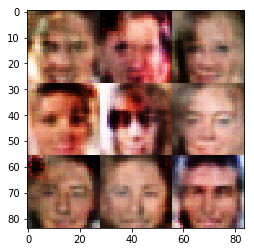

Epoch 1/1... Step 1010  Discriminator Loss: 1.6978... Generator Loss: 0.3617
Epoch 1/1... Step 1020  Discriminator Loss: 0.7553... Generator Loss: 1.6338
Epoch 1/1... Step 1030  Discriminator Loss: 0.6776... Generator Loss: 1.5990
Epoch 1/1... Step 1040  Discriminator Loss: 0.7303... Generator Loss: 1.9270
Epoch 1/1... Step 1050  Discriminator Loss: 1.6062... Generator Loss: 1.7628
Epoch 1/1... Step 1060  Discriminator Loss: 0.6128... Generator Loss: 1.7234
Epoch 1/1... Step 1070  Discriminator Loss: 0.5143... Generator Loss: 2.3060
Epoch 1/1... Step 1080  Discriminator Loss: 0.5401... Generator Loss: 2.2588
Epoch 1/1... Step 1090  Discriminator Loss: 0.6526... Generator Loss: 1.7297
Epoch 1/1... Step 1100  Discriminator Loss: 1.6663... Generator Loss: 1.7709


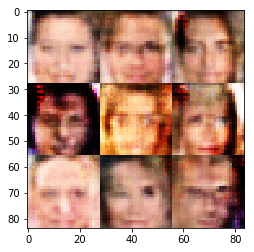

Epoch 1/1... Step 1110  Discriminator Loss: 1.0655... Generator Loss: 1.0077
Epoch 1/1... Step 1120  Discriminator Loss: 0.7638... Generator Loss: 1.3499
Epoch 1/1... Step 1130  Discriminator Loss: 0.7024... Generator Loss: 1.7156
Epoch 1/1... Step 1140  Discriminator Loss: 0.6574... Generator Loss: 1.5851
Epoch 1/1... Step 1150  Discriminator Loss: 1.1424... Generator Loss: 1.1343
Epoch 1/1... Step 1160  Discriminator Loss: 1.0858... Generator Loss: 0.7339
Epoch 1/1... Step 1170  Discriminator Loss: 0.5997... Generator Loss: 1.8128
Epoch 1/1... Step 1180  Discriminator Loss: 0.5460... Generator Loss: 2.4377
Epoch 1/1... Step 1190  Discriminator Loss: 0.9273... Generator Loss: 1.1327
Epoch 1/1... Step 1200  Discriminator Loss: 1.1744... Generator Loss: 2.5219


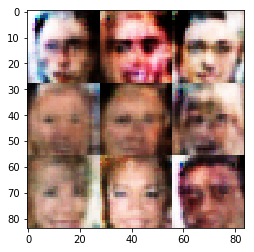

Epoch 1/1... Step 1210  Discriminator Loss: 0.5985... Generator Loss: 1.7914
Epoch 1/1... Step 1220  Discriminator Loss: 0.5304... Generator Loss: 2.3950
Epoch 1/1... Step 1230  Discriminator Loss: 1.3082... Generator Loss: 1.8521
Epoch 1/1... Step 1240  Discriminator Loss: 1.4006... Generator Loss: 0.5359
Epoch 1/1... Step 1250  Discriminator Loss: 0.7167... Generator Loss: 2.3220
Epoch 1/1... Step 1260  Discriminator Loss: 0.4818... Generator Loss: 2.5771
Epoch 1/1... Step 1270  Discriminator Loss: 0.7160... Generator Loss: 1.3052
Epoch 1/1... Step 1280  Discriminator Loss: 1.1162... Generator Loss: 0.7429
Epoch 1/1... Step 1290  Discriminator Loss: 0.8220... Generator Loss: 1.1246
Epoch 1/1... Step 1300  Discriminator Loss: 0.4642... Generator Loss: 2.6610


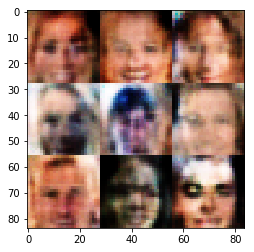

Epoch 1/1... Step 1310  Discriminator Loss: 0.4791... Generator Loss: 2.4835
Epoch 1/1... Step 1320  Discriminator Loss: 0.4836... Generator Loss: 2.4549
Epoch 1/1... Step 1330  Discriminator Loss: 0.4601... Generator Loss: 2.6811
Epoch 1/1... Step 1340  Discriminator Loss: 1.5386... Generator Loss: 0.4262
Epoch 1/1... Step 1350  Discriminator Loss: 0.7086... Generator Loss: 1.7093
Epoch 1/1... Step 1360  Discriminator Loss: 0.5592... Generator Loss: 3.6226
Epoch 1/1... Step 1370  Discriminator Loss: 0.5468... Generator Loss: 3.3198
Epoch 1/1... Step 1380  Discriminator Loss: 2.0676... Generator Loss: 4.2879
Epoch 1/1... Step 1390  Discriminator Loss: 0.7150... Generator Loss: 1.3798
Epoch 1/1... Step 1400  Discriminator Loss: 0.8521... Generator Loss: 1.1886


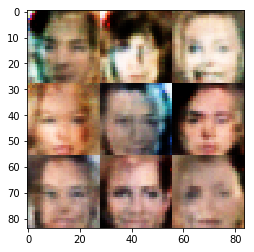

Epoch 1/1... Step 1410  Discriminator Loss: 1.5841... Generator Loss: 0.5345
Epoch 1/1... Step 1420  Discriminator Loss: 0.9398... Generator Loss: 0.9771
Epoch 1/1... Step 1430  Discriminator Loss: 0.8156... Generator Loss: 2.4406
Epoch 1/1... Step 1440  Discriminator Loss: 0.8259... Generator Loss: 1.0881
Epoch 1/1... Step 1450  Discriminator Loss: 0.7385... Generator Loss: 1.5112
Epoch 1/1... Step 1460  Discriminator Loss: 0.4560... Generator Loss: 3.3279
Epoch 1/1... Step 1470  Discriminator Loss: 0.9956... Generator Loss: 0.8303
Epoch 1/1... Step 1480  Discriminator Loss: 0.6975... Generator Loss: 1.5450
Epoch 1/1... Step 1490  Discriminator Loss: 0.6122... Generator Loss: 1.7942
Epoch 1/1... Step 1500  Discriminator Loss: 1.8663... Generator Loss: 4.3166


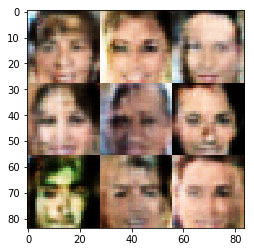

Epoch 1/1... Step 1510  Discriminator Loss: 0.6705... Generator Loss: 1.7496
Epoch 1/1... Step 1520  Discriminator Loss: 1.0903... Generator Loss: 1.4259
Epoch 1/1... Step 1530  Discriminator Loss: 0.7845... Generator Loss: 3.6724
Epoch 1/1... Step 1540  Discriminator Loss: 0.8533... Generator Loss: 1.0558
Epoch 1/1... Step 1550  Discriminator Loss: 0.6156... Generator Loss: 3.1628
Epoch 1/1... Step 1560  Discriminator Loss: 0.5193... Generator Loss: 3.1862
Epoch 1/1... Step 1570  Discriminator Loss: 0.8519... Generator Loss: 1.6896
Epoch 1/1... Step 1580  Discriminator Loss: 0.6146... Generator Loss: 1.6046


In [30]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [31]:
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
celeba_dataset.shape

(202599, 28, 28, 3)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.